Kaggle data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

We are challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate.

Dataset of comments from Wikipedia’s talk page edits.

Submissions are now evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column.

For each id in the test set, you must predict a probability for each of the six possible types of comment toxicity 
1. toxic
2. severe toxic
3. obscene
4. threat
5. insult
6. identity hate)

The columns must be in the same order as shown below. The file should contain a header and have the following format:

### Workflow

1. Preprocess data (use count vectorizer)
2. Make your data into 2 columns, X variable: reviews, Y varaible postive/negative
3. Train-test split your data
4. Train data on linear regression model
5. Create 2 spearate document term matrix (words only, bigram)
6. Use matplotlib, seaborn to create a confusion matrix to comparese 2 models in terms of F1 score, AUC score
7. Use Naive Bayes as well
8. Repeat step 1-7 with TF-IDF

### Observations while doing data:
1. Data has non-ASCII characters such as Chinese and Japanese characters. Had to remove them
2. Creating document term matrix with 159k rows led to Memory Error. not good. 

## Import relevant libraries and load the data

In [1]:
# !pip install nltk

import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import string

from nltk.corpus import stopwords  # Remove useless words
from nltk.chunk import ne_chunk  # Named Entity recognition
from nltk.stem.lancaster import LancasterStemmer  # Convert words to base form
from nltk.tag import pos_tag  # Helps to recognize whether the word is a noun, adj, etc.
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, MWETokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# nltk.download()

import pandas as pd

In [2]:
data = pd.read_csv('train.csv')
data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Exploratory data analysis

In [3]:
# There are 159,571 reviews in the dataset
len(data)

159571

In [4]:
data.toxic.value_counts(normalize=True)


0    0.904156
1    0.095844
Name: toxic, dtype: float64

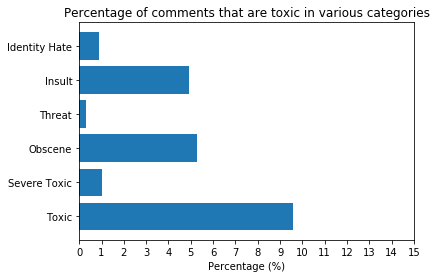

In [5]:
# Create a bar graph 
sum_tox = data['toxic'].sum() / 159571 * 100
sum_sev = data['severe_toxic'].sum() / 159571 * 100
sum_obs = data['obscene'].sum() / 159571 * 100
sum_thr = data['threat'].sum() / 159571 * 100
sum_ins = data['insult'].sum() / 159571 * 100
sum_ide = data['identity_hate'].sum() / 159571 * 100

ind = np.arange(6)
ax = plt.barh(ind, [sum_tox, sum_sev, sum_obs, sum_thr, sum_ins, sum_ide])

plt.xlabel('Percentage (%)')
plt.xticks(np.arange(16))
plt.title('Percentage of comments that are toxic in various categories')
plt.yticks(ind, ('Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate'))

plt.show()

In [6]:
# ax = data[('toxic','severe_toxic')].value_counts().plot(kind='barh', figsize=(10,7),
#                                         color="coral", fontsize=13);
# ax.set_alpha(0.8)
# ax.set_title("Where were the battles fought?", fontsize=18)
# ax.set_xlabel("Number of Battles", fontsize=18);
# ax.set_xticks([0, 5, 10, 15, 20])

# # create a list to collect the plt.patches data
# totals = []

# # find the values and append to list
# for i in ax.patches:
#     totals.append(i.get_width())

# # set individual bar lables using above list
# total = sum(totals)

# # set individual bar lables using above list
# for i in ax.patches:
#     # get_width pulls left or right; get_y pushes up or down
#     ax.text(i.get_width()+.3, i.get_y()+.38, \
#             str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
# color='dimgrey')

# # invert for largest on top 
# ax.invert_yaxis()

### Check for missing values

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [9]:
data['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [10]:
data['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [11]:
data['comment_text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

Seems like there are no missing values

### Preprocess the text

In [12]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [13]:
data['comment_text'][1]

'd aww  he matches this background colour i m seemingly stuck with  thanks    talk       january       utc '

In [14]:
data['comment_text'][2]

'hey man  i m really not trying to edit war  it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page  he seems to care more about the formatting than the actual info '

In [15]:
data['comment_text'][3]

'  more i can t make any real suggestions on improvement   i wondered if the section statistics should be later on  or a subsection of   types of accidents     i think the references may need tidying so that they are all in the exact same format ie date format etc  i can do that later on  if no one else does first   if you have any preferences for formatting style on references or want to do it yourself please let me know   there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up  it s listed in the relevant form eg wikipedia good article nominations transport   '

In [16]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0,0,0,0,0,0


## An alternative way to process is using TextBlob

In [17]:
# data = pd.read_csv('train.csv')


In [18]:
# from textblob import TextBlob

# for i in data['comment_text']:
#     data['new_text'] = TextBlob(i[1])


### Let's split the data into 6 smaller sections. Each section includes the ID, comment and 1 category for easier analysis.

In [19]:
# 159,750 unique observations

In [20]:
data_tox = data.loc[:,['id','comment_text','toxic']]

In [21]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [22]:
data_tox_10k = data.loc[0:10000,['id','comment_text','toxic']]

In [23]:
data_tox_10k

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0
5,00025465d4725e87,congratulations from me as well use the to...,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0
8,00037261f536c51d,sorry if the word nonsense was offensive to ...,0
9,00040093b2687caa,alignment on this subject and which are contra...,0


In [ ]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]

In [ ]:
data_obs = data.loc[:,['id','comment_text','obscene']]

In [ ]:
data_thr = data.loc[:,['id','comment_text','threat']]

In [ ]:
data_ins = data.loc[:,['id','comment_text','insult']]

In [ ]:
data_ide = data.loc[:,['id','comment_text','identity_hate']]

### Prepare data for modeling

In [24]:
# Import standard packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import LR, KNN, NB, SVM, DT, RF, XGB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
'''
Create a function that converts the Dataframe into a Count Vectorizer document term matrix.
Inputs: Dataframe, label of target variable with '', ngram_range: (1,2)

'''

def count_vectorizer(df,target):
    
    # Split the data into X and y data sets
    X = df.comment_text
    y = df[target]
    
    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
    # Create a Count Vectorizer object and remove stopwords from the table
    cv1 = CountVectorizer(stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train)
    X_test_cv1  = cv1.transform(X_test)
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
    print(test)

In [27]:
count_vectorizer(data_tox, 'toxic')

MemoryError: 

In [ ]:
data_tox_10k.shape

# Split the data into X and y data sets
X = data_tox_10k.comment_text
y = data_tox_10k['toxic']
    
# Split our data into training and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
# Create a Count Vectorizer object and remove stopwords from the table
cv1 = CountVectorizer(stop_words='english')
    
X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)
    
# Output a Dataframe of the CountVectorizer with unique words as the labels
test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())

test.shape
   

In [ ]:
test.iloc[0:10, 0:10]

In [ ]:
test.iloc[0:1, 30:50]

In [ ]:
criteria = test[test.iloc[0:3,:]>= 3 ]     


In [ ]:
import nltk
nltk.download('gutenberg')
nltk.download('genesis')
nltk.download('inaugural')
nltk.download('nps_chat')
nltk.download('webtext')
nltk.download('treebank')

from nltk.book import *
from nltk.probability import FreqDist

fdist1 = FreqDist(test) 

fdist1.most_common(20) 



In [ ]:
fdist1['fuck']

In [ ]:
'''
Create a function that converts the Dataframe into a TF-IDF document term matrix 
'''

def tf_idf(df):
    
    # Split the data into X and y data sets
    X = df.comment_text
    y = df[target]
    
    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create a Count Vectorizer object and remove stopwords from the table   
    tfidf1 = TfidfVectorizer(ngram_range = range, stop_words='english')
    X_train_tfidf1 = tfidf1.fit_transform(X_train)
    X_test_tfidf1  = tfidf1.transform(X_test)

    # Output a Dataframe of the CountVectorizer with unique words as the labels
    pd.DataFrame(X_train_tfidf1.toarray(), columns=tfidf1.get_feature_names()).head()


In [ ]:
# # The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
# cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

# X_train_cv2 = cv2.fit_transform(X_train)
# X_test_cv2  = cv2.transform(X_test)

# pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

### Try classifying using Logistic Regression

In [ ]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [ ]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [ ]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [ ]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

In [ ]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

Comparing the two models, the first model has better precision, while the second model has better accuracy and recall.

### Try classifying using Naive Bayes

In [ ]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [ ]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

In [ ]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

In [ ]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

The first Naive Bayes model outperforms both Logistic Regression models.

### Try using TF-IDF instead of Count Vectorizer

In [ ]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

In [ ]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

In [ ]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

In [ ]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

In [ ]:
# Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm7, cm8)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

It looks like using TF-IDF, we were able to improve the recall, but the accuracy and precision of the first Naive Bayes model still outperforms the other models.

Overall, the first Naive Bayes model (using unigrams and counts) seems to best classify positive and negative cappuccino cup reviews.

In [ ]:
# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(len(data['toxic']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Tabulate the total number of comments which fall into various categories
totals = [i+j+k for i,j,k in zip(data['toxic'], data['severe_toxic'], data['obscene'], data['threat'], data['insult'], data['identity_hate'])]

# Find the % of comments that are toxic
toxic_percent = [i / j * 100 for i,j in zip(data['toxic'], totals)]

# Find the % of comments that are severe_toxic
severe_percent = [i / j * 100 for  i,j in zip(data['severe_toxic'], totals)]

# Find the % of comments that are obscene
obscene_percent = [i / j * 100 for  i,j in zip(data['obscene'], totals)]

# Find the % of comments that are threat
threat_percent = [i / j * 100 for  i,j in zip(data['threat'], totals)]

# Find the % of comments that are insult
insult_percent = [i / j * 100 for  i,j in zip(data['insult'], totals)]

# Find the % of comments that are identity hate
obscene = [i / j * 100 for  i,j in zip(data['identity_hate'], totals)]


# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using pre_rel data
       toxic_percent, 
       # labeled 
       label='Pre Score', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#019600',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using mid_rel data
       mid_rel, 
       # with pre_rel
       bottom=pre_rel, 
       # labeled 
       label='Mid Score', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3C5F5A', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using post_rel data
       post_rel, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j for i,j in zip(pre_rel, mid_rel)], 
       # labeled 
       label='Post Score',
       # with alpha
       alpha=0.9, 
       # with color
       color='#219AD8', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Set the ticks to be first names
plt.xticks(tick_pos, df['first_name'])
ax.set_ylabel("Percentage")
ax.set_xlabel("")

# Let the borders of the graphic
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.ylim(-10, 110)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

# shot plot
plt.show()